# Imports et chargement des données

In [1]:
import os
import gc
from datetime import datetime
from importlib import reload  
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score #, precision_recall_curve, , average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import lightgbm as lgbm
from lightgbm import LGBMClassifier


# mes modules
import kagfonct as kf

In [2]:
PATH = "./data/"
for fic in os.listdir(PATH):
    print(fic)
# print(os.listdir(path))   

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description - Copy.csv
HomeCredit_columns_description - test.csv
HomeCredit_columns_description - utf8.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
Projet+Mise+en+prod+-+home-credit-default-risk.zip
sample_submission.csv


In [3]:
df_application_test = pd.read_csv(PATH+"application_test.csv")
df_application_train = pd.read_csv(PATH+"application_train.csv")
df_bureau = pd.read_csv(PATH+"bureau.csv")
df_bureau_balance = pd.read_csv(PATH+"bureau_balance.csv")
df_credit_card_balance = pd.read_csv(PATH+"credit_card_balance.csv")
df_payments = pd.read_csv(PATH+"installments_payments.csv")
df_pos_cash_balance = pd.read_csv(PATH+"POS_CASH_balance.csv")
df_prev_app = pd.read_csv(PATH+"previous_application.csv")
# df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description - utf8.csv")
df_homecredit = pd.read_csv(PATH+"HomeCredit_columns_description.csv", encoding = "cp1252")

NB : le fichier "HomeCredit_columns_description.csv" comporte à plusieurs reprises, un caractère qui n'est pas dans la norme utf-8 (…)

In [4]:
df_homecredit.loc[12,"Description"]

'Clients income type (businessman, working, maternity leave,…)'

# Fonctions

# Exploration

In [5]:
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [6]:
df_application_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
60833,170546,0,Cash loans,M,Y,N,0,225000.0,436032.0,34578.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,7.0
38754,144886,0,Cash loans,F,N,Y,0,135000.0,463131.0,22410.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
9337,110854,0,Cash loans,M,Y,Y,0,195750.0,545040.0,26640.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
177179,305320,0,Cash loans,F,N,Y,0,337500.0,1128595.5,31032.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
136282,258076,0,Cash loans,F,Y,N,1,112500.0,1061599.5,31171.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
296471,443482,0,Cash loans,F,N,Y,1,90000.0,808650.0,29839.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0
9055,110530,0,Cash loans,M,N,Y,0,76500.0,165024.0,7821.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
137248,259175,0,Cash loans,F,N,Y,0,81000.0,526491.0,19039.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
80281,193073,0,Cash loans,M,N,N,0,360000.0,254700.0,16582.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
90546,205123,0,Cash loans,F,N,Y,2,265500.0,1339884.0,39307.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [7]:
# Nombre de colonnes ayant des valeurs nulles
(df_application_train.isnull().sum()>0).sum()

67

In [8]:
df_homecredit[df_homecredit["Table"]=="application_{train|test}.csv"]

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [9]:
list(df_homecredit.loc[(df_homecredit["Table"]=="application_{train|test}.csv") & (df_homecredit["Row"]=="TARGET"), 
                       "Description"])

['Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']

In [10]:
list(df_application_train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [11]:
df_application_test.sample(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
10274,174631,Cash loans,F,N,Y,0,198000.0,278460.0,21676.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
4454,131905,Cash loans,F,N,Y,1,270000.0,292500.0,15997.5,292500.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
15759,213604,Cash loans,M,Y,Y,2,247500.0,278460.0,25668.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
22164,261111,Cash loans,F,N,N,0,90000.0,469017.0,23944.5,391500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
47952,450412,Cash loans,F,N,N,1,126000.0,272520.0,21528.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
30844,324075,Cash loans,F,N,Y,1,202500.0,582804.0,24822.0,463500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0
26194,290727,Cash loans,F,N,N,1,135000.0,450000.0,19066.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
36050,363762,Cash loans,F,Y,N,1,279000.0,234369.0,13585.5,193500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
31378,328144,Cash loans,M,Y,Y,0,270000.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
24960,281905,Cash loans,F,Y,Y,0,171000.0,171000.0,13230.0,171000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [12]:
df_bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
905568,392799,5668472,Closed,currency 1,-1104,0,-738.0,-766.0,NaN,0,89004.780,0.0,NaN,0.0,Consumer credit,-710,15049.17
196360,311107,6262540,Closed,currency 1,-1456,0,-360.0,-1092.0,0.0,0,310500.000,0.0,0.0,0.0,Consumer credit,-1092,NaN
358574,183476,6823682,Closed,currency 1,-737,0,-191.0,-281.0,NaN,0,50989.500,0.0,0.0,0.0,Consumer credit,-276,NaN
1397262,247075,5277975,Closed,currency 1,-2671,0,-2578.0,-2059.0,NaN,0,32427.000,0.0,0.0,0.0,Consumer credit,-844,NaN
872261,113347,5661821,Closed,currency 1,-1530,0,-1408.0,-1408.0,NaN,0,33471.000,NaN,NaN,0.0,Consumer credit,-1408,NaN
1463026,183566,5367311,Closed,currency 1,-685,0,-139.0,-447.0,0.0,0,315000.000,NaN,NaN,0.0,Consumer credit,-447,NaN
122200,268365,6363426,Closed,currency 1,-1960,0,-1778.0,-1870.0,0.0,0,33840.000,0.0,0.0,0.0,Consumer credit,-1441,NaN
116184,133241,5011002,Closed,currency 1,-1055,0,-690.0,-689.0,NaN,0,56250.000,0.0,0.0,0.0,Consumer credit,-688,18414.00
614381,322248,6401159,Closed,currency 1,-1303,0,-1119.0,-1119.0,0.0,0,33677.775,0.0,0.0,0.0,Consumer credit,-135,NaN
11972,428356,6021045,Active,currency 1,-8,0,1819.0,NaN,NaN,0,139500.000,139500.0,0.0,0.0,Consumer credit,-3,4225.50


In [13]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau.isnull().sum()>0).sum()

7

In [14]:
df_bureau[df_bureau["SK_ID_CURR"]==368092]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
514934,368092,6457783,Closed,currency 1,-487,0,-122.0,-121.0,NaN,0,114750.0,0.0,0.0,0.0,Consumer credit,-116,0.0
514935,368092,6457784,Closed,currency 1,-1676,0,-580.0,-1505.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-1423,5044.5
514936,368092,6457785,Closed,currency 1,-1676,0,-580.0,-610.0,NaN,0,270000.0,0.0,0.0,0.0,Consumer credit,-339,0.0
514937,368092,6457786,Closed,currency 1,-1819,0,-1547.0,-1197.0,NaN,0,83385.0,NaN,NaN,0.0,Consumer credit,-1194,0.0


In [15]:
df_bureau_balance[df_bureau_balance["SK_ID_BUREAU"]== 6457783]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
10396161,6457783,0,C
10396162,6457783,-1,C
10396163,6457783,-2,C
10396164,6457783,-3,C
10396165,6457783,-4,C
10396166,6457783,-5,0
10396167,6457783,-6,0
10396168,6457783,-7,0
10396169,6457783,-8,X
10396170,6457783,-9,0


In [16]:
df_bureau_balance["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [17]:
# Nombre de colonnes ayant des valeurs nulles
(df_bureau_balance.isnull().sum()>0).sum()

0

In [18]:
df_homecredit[df_homecredit["Table"]=="bureau_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,144,bureau_balance.csv,STATUS,Status of Credit Bureau loan during the month ...,NaN


In [19]:
df_pos_cash_balance[df_pos_cash_balance["SK_ID_CURR"]==368092].sort_values(by="MONTHS_BALANCE")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9535021,2198792,368092,-82,12.0,12.0,Active,0,0
948279,2198792,368092,-81,12.0,11.0,Active,0,0
9001077,2198792,368092,-80,12.0,10.0,Active,0,0
6410934,2198792,368092,-79,12.0,9.0,Active,0,0
4157178,2198792,368092,-78,12.0,8.0,Active,0,0
4097603,2198792,368092,-77,12.0,7.0,Active,0,0
1377294,2198792,368092,-76,12.0,6.0,Active,0,0
2462432,2198792,368092,-75,12.0,5.0,Active,0,0
3171983,2198792,368092,-74,12.0,4.0,Active,0,0
3216998,2198792,368092,-73,12.0,3.0,Active,0,0


In [20]:
# Nombre de colonnes ayant des valeurs nulles
(df_pos_cash_balance.isnull().sum()>0).sum()

2

In [21]:
df_homecredit[df_homecredit["Table"]=="POS_CASH_balance.csv"]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


In [22]:
df_credit_card_balance.sample(10)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1140579,2210921,242340,-6,0.000,180000,0.0,0.000,0.0,0.000,7248.015,...,0.000,0.000,0.0,0,0.0,0.0,8.0,Active,0,0
2618563,2328449,125573,-32,0.000,0,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,16.0,Active,0,0
1039181,1683952,157629,-39,278149.320,270000,9000.0,9000.000,0.0,0.000,13500.000,...,278149.320,278149.320,1.0,1,0.0,0.0,61.0,Active,0,0
3631859,1936754,300243,-5,146244.690,135000,0.0,0.000,0.0,0.000,4749.255,...,144535.320,144535.320,0.0,0,0.0,0.0,4.0,Active,0,0
201837,1130375,321514,-50,0.000,135000,0.0,0.000,0.0,0.000,0.000,...,-3720.015,-3720.015,0.0,0,0.0,0.0,42.0,Active,0,0
861002,1106979,120558,-32,0.000,90000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,14.0,Active,0,0
1709502,2729956,345120,-12,247003.470,765000,58500.0,62146.035,0.0,3646.035,9560.835,...,242966.970,242966.970,3.0,9,0.0,6.0,3.0,Active,0,0
446256,1338305,242022,-89,0.000,135000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,27.0,Active,0,0
3364292,1764706,330663,-72,0.000,90000,0.0,0.000,0.0,0.000,0.000,...,0.000,0.000,0.0,0,0.0,0.0,13.0,Active,0,0
276622,2105770,424143,-4,239137.515,900000,45000.0,106859.430,0.0,61859.430,2366.820,...,232054.515,232054.515,4.0,10,0.0,6.0,1.0,Active,0,0


In [23]:
# Nombre de colonnes ayant des valeurs nulles
(df_credit_card_balance.isnull().sum()>0).sum()

9

In [24]:
df_prev_app.sample(10)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1563077,1848310,401065,Cash loans,19151.100,450000.000,533160.0,NaN,450000.000,MONDAY,5,...,XNA,48.0,low_normal,Cash X-Sell: low,365243.0,-405.0,1005.0,365243.0,365243.0,1.0
1033762,2827543,102404,Cash loans,11385.180,90000.000,95940.0,NaN,90000.000,FRIDAY,10,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-687.0,-357.0,-627.0,-623.0,1.0
224829,1694398,256251,Consumer loans,8525.745,92420.595,83178.0,9242.595,92420.595,THURSDAY,19,...,Consumer electronics,12.0,middle,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN
1564398,1834802,340469,Cash loans,52919.280,1125000.000,1255680.0,NaN,1125000.000,SATURDAY,13,...,XNA,48.0,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
587945,1999754,393384,Cash loans,17514.000,450000.000,450000.0,NaN,450000.000,FRIDAY,0,...,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-394.0,1016.0,-334.0,-319.0,0.0
1667356,1128038,136109,Consumer loans,2110.950,14841.000,16065.0,0.000,14841.000,TUESDAY,7,...,Consumer electronics,10.0,high,POS household with interest,365243.0,-2405.0,-2135.0,-2135.0,-2130.0,1.0
1387372,1945584,413988,Consumer loans,30384.045,274410.000,244048.5,45000.000,274410.000,SUNDAY,14,...,Consumer electronics,10.0,middle,POS household with interest,365243.0,-2141.0,-1871.0,-1871.0,-1864.0,0.0
248047,1916065,290838,Cash loans,29971.035,450000.000,640080.0,NaN,450000.000,SATURDAY,9,...,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-186.0,1224.0,365243.0,365243.0,1.0
489460,2323074,305849,Revolving loans,22500.000,0.000,450000.0,NaN,NaN,MONDAY,10,...,XNA,0.0,XNA,Card X-Sell,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
71401,1121244,355372,Consumer loans,5414.310,27598.500,29236.5,0.000,27598.500,WEDNESDAY,19,...,Jewelry,6.0,middle,POS others without interest,365243.0,-118.0,32.0,365243.0,365243.0,0.0


In [25]:
# Nombre de colonnes ayant des valeurs nulles
(df_prev_app.isnull().sum()>0).sum()

16

In [26]:
df_prev_app[df_prev_app["SK_ID_CURR"]==368092]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
132593,2198792,368092,Consumer loans,5921.37,122764.14,60732.0,67504.14,122764.14,MONDAY,13,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2475.0,-2145.0,-2145.0,-2136.0,1.0


In [27]:
df_payments.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3985382,1870038,220030,1.0,8,-1534.0,-1586.0,8687.205,8687.205
8837344,2032735,399412,1.0,2,-308.0,-321.0,33463.665,33463.665
8033434,2011395,388558,0.0,40,-2092.0,-2107.0,3375.000,3375.000
1430726,1717271,120458,1.0,11,-335.0,-341.0,10185.120,10185.120
7416666,1290237,204776,1.0,7,-1582.0,-1601.0,6145.470,7.425
5375248,1926753,247259,1.0,1,-992.0,-1003.0,13860.180,13860.180
1465000,2510455,170046,1.0,15,-1019.0,-1042.0,9014.445,4320.585
10290618,2150187,356775,0.0,69,-1339.0,-1339.0,521.505,521.505
13524994,2090167,421765,1.0,3,-1098.0,-1101.0,8174.700,8174.700
10912102,1690599,382221,1.0,2,-2354.0,-2356.0,2099.250,2099.250


In [28]:
# Nombre de colonnes ayant des valeurs nulles
(df_payments.isnull().sum()>0).sum()

2

In [29]:
df_payments[df_payments["SK_ID_CURR"]==368092].sort_values(by="NUM_INSTALMENT_NUMBER")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
8624343,2198792,368092,1.0,1,-2475.0,-2485.0,5921.37,5921.37
8085854,2198792,368092,1.0,2,-2445.0,-2447.0,5921.37,5921.37
9254042,2198792,368092,1.0,3,-2415.0,-2419.0,5921.37,5921.37
7829329,2198792,368092,1.0,4,-2385.0,-2387.0,5921.37,5921.37
9254285,2198792,368092,1.0,5,-2355.0,-2358.0,5921.37,5921.37
10778313,2198792,368092,1.0,6,-2325.0,-2344.0,5921.37,5921.37
9235293,2198792,368092,1.0,7,-2295.0,-2296.0,5921.37,5921.37
8320158,2198792,368092,1.0,8,-2265.0,-2274.0,5921.37,5921.37
11155326,2198792,368092,1.0,9,-2235.0,-2246.0,5921.37,5921.37
11034595,2198792,368092,1.0,10,-2205.0,-2204.0,5921.37,5921.37


# Feature Engineering

## Intégration des données

In [30]:
reload(kf)

<module 'kagfonct' from 'D:\\Laure\\AnacondaProjects\\20 - openclassrooms - datascientist\\10 - parcoursDS\\7 - Scoring\\modelisation\\kagfonct.py'>

In [31]:
data, y = kf.build_model_input(PATH)

Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
            SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
SK_ID_CURR                                                  
100001               7.0  -735.000000                 0.0   
100002               8.0  -874.000000                 0.0   
100003               4.0 -1400.750000                 0.0   
100004               2.0  -867.000000                 0.0   
100005               3.0  -190.666667                 0.0   

            DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
SK_ID_CURR                                                                   
100001                82.428571        -825.500000                     NaN   
100002              -349.000000        -697.500000                1681.029   
100003              -544.500000       -1097.333333                   0.000   
100

Go to dummies
Compute nb of prevs per curr
Go to averages
Reading CC balance
Go to dummies
Compute average
Reading Installments
Read data
Shapes :  (307511, 122)


In [32]:
# suppression des colonnes qui sont en fait des indexes
applicants = data["SK_ID_CURR"]
data.drop(columns = [x for x in list(data.columns) if 'SK_ID' in x], inplace=True)

## Analyse du résultat

In [33]:
print("taille des données : ", data.shape)
print("taille des prévisions : ", y.shape)

taille des données :  (307511, 374)
taille des prévisions :  (307511,)


In [34]:
y.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [35]:
print(f"pourcentage de personnes ayant des difficultés de paiement : {(y==1).sum()/len(y)*100:.1f}%")

pourcentage de personnes ayant des difficultés de paiement : 8.1%


In [36]:
data.sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
194450,0,1,0,1,0,157500.0,453816.0,11970.0,297000.0,-1,...,NaN,NaN,NaN,NaN,1.000000,4.500000,-130.000000,-146.375000,27900.855000,27900.855000
248394,0,1,0,0,0,54000.0,717003.0,20677.5,598500.0,1,...,NaN,NaN,NaN,NaN,1.125000,4.625000,-1700.041667,-1723.791667,12595.128750,12595.128750
258720,1,0,1,0,1,360000.0,202500.0,10125.0,202500.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117667,0,0,0,1,0,121500.0,238500.0,15547.5,238500.0,0,...,NaN,NaN,NaN,NaN,1.000000,10.000000,-290.000000,-304.315789,12695.175000,12695.175000
133470,0,0,1,0,0,112500.0,254700.0,17149.5,225000.0,0,...,NaN,NaN,NaN,NaN,1.058824,3.352941,-227.176471,-247.235294,8317.016471,8317.016471
65826,0,0,1,0,0,112500.0,1288350.0,37800.0,1125000.0,0,...,NaN,NaN,NaN,NaN,1.176471,3.941176,-1592.647059,-1609.823529,4209.697059,4209.697059
276169,0,0,0,0,1,112500.0,450000.0,17095.5,450000.0,1,...,NaN,NaN,NaN,NaN,1.000000,5.900000,-1258.200000,-1279.100000,6537.442500,6537.442500
154467,0,1,1,1,3,135000.0,454500.0,30271.5,454500.0,6,...,0.0,0.0,0.0,0.0,0.206897,19.982759,-241.034483,-242.655172,24922.305000,24922.305000
169666,0,1,0,0,0,135000.0,1615968.0,56299.5,1395000.0,0,...,0.0,0.0,0.0,0.0,0.946309,33.812081,-721.865772,-730.114094,22702.281040,28729.865839
213752,0,1,1,0,0,180000.0,1540588.5,42493.5,1377000.0,0,...,NaN,NaN,NaN,NaN,1.111111,4.000000,-2283.833333,-2290.166667,9900.360000,9900.360000


## Valeurs nulles

Pour le traitement des valeurs nulles, nous devons tenir compte du fait que le taux de personnes ayant des difficultés de paiement est de 8%. Il ne faut donc pas supprimer trop rapidement des valeurs qui pourraient être significatives pour ces personnes.

In [37]:
data.isnull().sum().sort_values(ascending=False)

RATE_INTEREST_PRIMARY                302902
RATE_INTEREST_PRIVILEGED             302902
cc_bal_AMT_PAYMENT_CURRENT           246451
cc_bal_AMT_DRAWINGS_OTHER_CURRENT    246371
cc_bal_CNT_DRAWINGS_ATM_CURRENT      246371
                                      ...  
HOUSETYPE_MODE                            0
REG_CITY_NOT_LIVE_CITY                    0
LIVE_REGION_NOT_WORK_REGION               0
REG_REGION_NOT_WORK_REGION                0
NAME_CONTRACT_TYPE                        0
Length: 374, dtype: int64

In [38]:
# Nombre de colonnes ayant des valeurs nulles
(data.isnull().sum()>0).value_counts()

True     315
False     59
dtype: int64

In [39]:
# Nombre de lignes ayant des valeurs nulles
(data.isnull().sum(axis=1)>0).value_counts()

True     307494
False        17
dtype: int64

In [40]:
# Nombre de colonnes ayant moins de 1% de valeurs nulles
((data.isnull().sum()/data.count()*100)<1).value_counts()

False    306
True      68
dtype: int64

In [41]:
data.describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,...,86905.000000,86905.000000,86905.000000,86905.000000,291643.000000,291643.000000,291643.000000,291635.000000,2.916430e+05,2.916350e+05
mean,0.095213,0.658370,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.277512,...,0.000106,0.000002,0.000064,0.003738,1.041501,9.764795,-909.662335,-920.961181,1.839261e+04,1.875431e+04
std,0.293509,0.474284,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.722458,...,0.008740,0.000155,0.000877,0.031882,0.602107,11.273675,598.461681,597.024650,2.333797e+04,2.510536e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2922.000000,-3071.000000,0.000000e+00,1.890000e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,4.555556,-1301.959806,-1311.842195,7.799513e+03,7.478370e+03
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.017241,6.045455,-795.953488,-807.581818,1.257265e+04,1.222576e+04
75%,0.000000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.111111,9.434413,-419.000000,-431.609963,2.137614e+04,2.135286e+04
max,1.000000,2.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,6.000000,...,0.915789,0.013889,0.024390,1.000000,39.000000,138.110063,-3.000000,-3.000000,2.504590e+06,2.504590e+06


In [42]:
data.mean()

NAME_CONTRACT_TYPE                0.095213
CODE_GENDER                       0.658370
FLAG_OWN_CAR                      0.340108
FLAG_OWN_REALTY                   0.306327
CNT_CHILDREN                      0.417052
                                  ...     
inst_NUM_INSTALMENT_NUMBER        9.764795
inst_DAYS_INSTALMENT           -909.662335
inst_DAYS_ENTRY_PAYMENT        -920.961181
inst_AMT_INSTALMENT           18392.611499
inst_AMT_PAYMENT              18754.310245
Length: 374, dtype: float64

Pour les classifiers n'acceptant pas les valeurs nulles, nous les remplaceront par la moyenne.  
Ce n'est pas le cas de LGBM Classifier.

# Prévisions

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)

## LGBMClassifier

### 1ière approche

In [44]:
%%time
print(f"Heure de début : {str(datetime.now())}")

clf = LGBMClassifier(n_estimators=100)
# params = {"n_estimators" : range(100, 500, 100), "learning_rate" : np.arange(0.05, 0.13, 0.01)}
params = {"learning_rate" : np.logspace(-3, 2, 6), "class_weight":[None, "balanced"]}

model_cv=GridSearchCV(clf, params, cv=5, scoring='roc_auc', verbose=10)
model_cv.fit(X_train, y_train)

Heure de début : 2020-04-13 10:40:51.411046
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=None, learning_rate=0.001, score=0.717, total=   7.4s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.719, total=   7.3s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.711, total=   7.1s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.9s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.719, total=   7.4s
[CV] class_weight=None, learning_rate=0.001 ..........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.4s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.001, score=0.710, total=   7.5s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.9s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.738, total=   7.8s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   44.8s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.738, total=   7.6s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   52.4s remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.732, total=   7.7s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.739, total=   7.5s
[CV] class_weight=None, learning_rate=0.01 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV]  class_weight=None, learning_rate=0.01, score=0.732, total=   7.8s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.776, total=   6.5s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.773, total=   6.8s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.766, total=   6.7s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.773, total=   6.6s
[CV] class_weight=None, learning_rate=0.1 ............................
[CV]  class_weight=None, learning_rate=0.1, score=0.771, total=   6.8s
[CV] class_weight=None, learning_rate=1.0 ............................
[CV]  class_weight=None, learning_rate=1.0, score=0.720, total=   4.9s
[CV] class_weight=None, learning_rate=1.0 ............................
[CV] 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.9min finished


Wall time: 6min 1s


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [None, 'balanced'],
                         'learnin

In [45]:
print("best score : ", model_cv.best_score_)
print("best params_ : ", model_cv.best_params_)

best score :  0.7738448640709108
best params_ :  {'class_weight': 'balanced', 'learning_rate': 0.1}


In [46]:
%%time
clf = LGBMClassifier(n_estimators=100, learning_rate=model_cv.best_params_["learning_rate"], 
                     class_weight=model_cv.best_params_["class_weight"])
clf.fit(X_train, y_train)

Wall time: 8.23 s


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [47]:
ret = clf.predict_proba(X_test)
roc_auc_score(y_test, ret[:,1])

0.7776865131370082

In [48]:
fpr, tpr, th = roc_curve(y_test, ret[:,1])
auc_test =  auc(fpr, tpr)
auc_test

0.7776865131370082

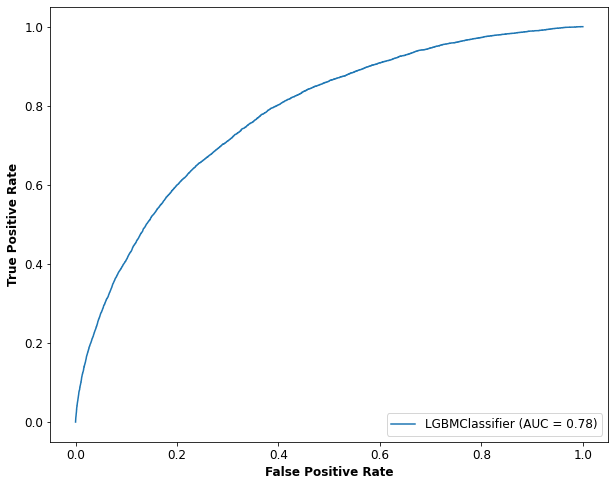

In [49]:
plt.rcParams.update({"font.size" : 12, 'axes.titleweight':"bold", 'axes.labelweight': 'bold', \
                         "figure.figsize":[10,8], "savefig.bbox":"tight"})
plot_roc_curve(clf, X_test, y_test)
plt.show()

In [50]:
df_feature_importance = pd.DataFrame()
df_feature_importance["feature"] = data.columns
df_feature_importance["occurences"] = clf.feature_importances_
df_feature_importance

,feature,occurences
0,NAME_CONTRACT_TYPE,19
1,CODE_GENDER,35
2,FLAG_OWN_CAR,0
3,FLAG_OWN_REALTY,1
4,CNT_CHILDREN,0
...,...,...
369,inst_NUM_INSTALMENT_NUMBER,22
370,inst_DAYS_INSTALMENT,7
371,inst_DAYS_ENTRY_PAYMENT,16
372,inst_AMT_INSTALMENT,4


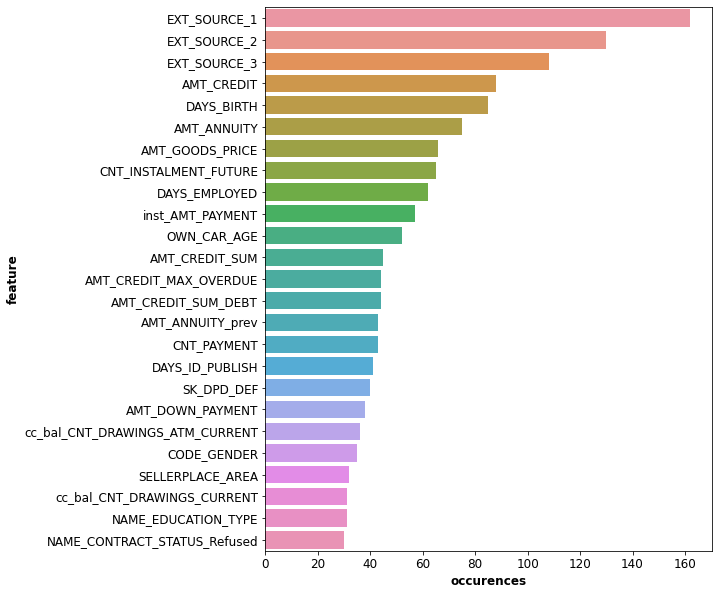

In [51]:
plt.figure(figsize=(8,10))
sns.barplot(x="occurences", y="feature", 
            data=df_feature_importance.sort_values(by="occurences", ascending=False)[:25])
plt.show()

In [52]:
df_homecredit[df_homecredit["Row"].isin(["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"])].sort_values(by="Row")

,Unnamed: 0,Table,Row,Description,Special
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN
138,141,bureau.csv,AMT_ANNUITY,Annuity of the Credit Bureau credit,NaN
176,179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
178,181,previous_application.csv,AMT_CREDIT,Final credit amount on the previous applicatio...,NaN
10,13,application_{train|test}.csv,AMT_GOODS_PRICE,For consumer loans it is the price of the good...,NaN
180,183,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN


In [53]:
df_feature_importance.sort_values(by="occurences", ascending=False)[:25]

,feature,occurences
39,EXT_SOURCE_1,162
40,EXT_SOURCE_2,130
41,EXT_SOURCE_3,108
6,AMT_CREDIT,88
15,DAYS_BIRTH,85
7,AMT_ANNUITY,75
8,AMT_GOODS_PRICE,66
329,CNT_INSTALMENT_FUTURE,65
16,DAYS_EMPLOYED,62
373,inst_AMT_PAYMENT,57


In [54]:
del clf
gc.collect()

9612

### Modification des paramètres

#### Optimisation des paramètres

In [190]:
%%time
print(f"Heure de début : {str(datetime.now())}")

lgbm_train = lgbm.Dataset(data=X_train,
                          label=y_train,
#                           categorical_feature=categorical_feats,
#                          free_raw_data=False
                         )
lgbm_valid = lgbm.Dataset(data=X_test,
                          label=y_test,
                         )
#‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest.
# for boost in ["gbdt", "dart", "goss"]:
#     print(boost)
# for drop in np.linspace(0.02, 0.04, 5):
#     print(drop)
# for regl2 in np.linspace(13, 21, 9):
#     print(regl2)
# for regl1 in np.linspace(10, 50, 5):
#     print(regl1)
# for scale in np.linspace(1, 15, 5):
#     print(scale)
# for lambd in np.linspace(0.1, 0.4, 4):
#     print(lambd)
lgbm_params = {
'boosting': 'dart',
'application': 'binary',
'learning_rate': 0.1,
'min_data_in_leaf': 30,
'num_leaves': 31,
'max_depth': -1,
'feature_fraction': 0.5,
'scale_pos_weight': 2,
'drop_rate': 0.025,
'metrics': 'auc',
'class_weight': 'balanced',
'reg_lambda' : 14,
'sigmoid' : 0.3
}

cv_results = lgbm.cv(train_set=lgbm_train,
             params=lgbm_params,
             nfold=5,
             num_boost_round=1000,
#                          early_stopping_rounds=100,
             verbose_eval=100,
             metrics=['auc']
                    )

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))



Heure de début : 2020-04-13 18:55:48.436403
[100]	cv_agg's auc: 0.769941 + 0.00312626
[200]	cv_agg's auc: 0.77383 + 0.00304825
[300]	cv_agg's auc: 0.777242 + 0.00282248
[400]	cv_agg's auc: 0.778786 + 0.00256607
[500]	cv_agg's auc: 0.779343 + 0.00285194
[600]	cv_agg's auc: 0.779609 + 0.00259216
[700]	cv_agg's auc: 0.779748 + 0.00264362
[800]	cv_agg's auc: 0.77977 + 0.00274564
[900]	cv_agg's auc: 0.780123 + 0.00271097
[1000]	cv_agg's auc: 0.78019 + 0.00263506
Optimum boost rounds = 986
Best CV result = 0.7802854372091749
Wall time: 3min 34s


lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.025,
    'metrics': 'auc',
    'class_weight': 'balanced'
}

    cv_results = lgbm.cv(train_set=lgbm_train,
                         params=lgbm_params,
                         nfold=5,
                         num_boost_round=800,
                         verbose_eval=100,
                         metrics=['auc'])

    optimum_boost_rounds = np.argmax(cv_results['auc-mean'])


Heure de début : 2020-04-11 20:26:46.603387
0.02
[100]	cv_agg's auc: 0.773088 + 0.00255023
[200]	cv_agg's auc: 0.775635 + 0.00225597
[300]	cv_agg's auc: 0.776989 + 0.00206449
[400]	cv_agg's auc: 0.777455 + 0.00216721
[500]	cv_agg's auc: 0.777691 + 0.00255026
[600]	cv_agg's auc: 0.778041 + 0.00246902
[700]	cv_agg's auc: 0.777825 + 0.0024079
[800]	cv_agg's auc: 0.777157 + 0.00246348
Optimum boost rounds = 603
Best CV result = 0.7780798311510145
0.025
[100]	cv_agg's auc: 0.772456 + 0.00320206
[200]	cv_agg's auc: 0.775227 + 0.00288794
[300]	cv_agg's auc: 0.77709 + 0.00324927
[400]	cv_agg's auc: 0.777783 + 0.003206
[500]	cv_agg's auc: 0.778136 + 0.00269442
[600]	cv_agg's auc: 0.778332 + 0.00281982
[700]	cv_agg's auc: 0.778255 + 0.00294485
[800]	cv_agg's auc: 0.778398 + 0.00289406
Optimum boost rounds = 756
Best CV result = 0.7785181457020898
0.03
[100]	cv_agg's auc: 0.771024 + 0.00244353
[200]	cv_agg's auc: 0.774172 + 0.00307985
[300]	cv_agg's auc: 0.776454 + 0.00309466
[400]	cv_agg's auc: 0.777526 + 0.00287629
[500]	cv_agg's auc: 0.777716 + 0.00289826
[600]	cv_agg's auc: 0.778056 + 0.00272095
[700]	cv_agg's auc: 0.777985 + 0.00300464
[800]	cv_agg's auc: 0.777861 + 0.00315963
Optimum boost rounds = 634
Best CV result = 0.7782285385826053
0.035
[100]	cv_agg's auc: 0.771144 + 0.00242752
[200]	cv_agg's auc: 0.773802 + 0.00268475
[300]	cv_agg's auc: 0.776399 + 0.00306292
[400]	cv_agg's auc: 0.777278 + 0.00287393
[500]	cv_agg's auc: 0.777671 + 0.00255469
[600]	cv_agg's auc: 0.778086 + 0.00249929
[700]	cv_agg's auc: 0.777918 + 0.00250147
[800]	cv_agg's auc: 0.778018 + 0.00241396
Optimum boost rounds = 579
Best CV result = 0.7782464595186538
0.04
[100]	cv_agg's auc: 0.770189 + 0.00272112
[200]	cv_agg's auc: 0.773782 + 0.00289326
[300]	cv_agg's auc: 0.775702 + 0.00293387
[400]	cv_agg's auc: 0.776967 + 0.00277938
[500]	cv_agg's auc: 0.777314 + 0.00265795
[600]	cv_agg's auc: 0.777638 + 0.00273892
[700]	cv_agg's auc: 0.777634 + 0.00272675
[800]	cv_agg's auc: 0.777594 + 0.00282528
Optimum boost rounds = 716
Best CV result = 0.7777929765260263
Wall time: 12min 26s


Wall time: 48.8 s


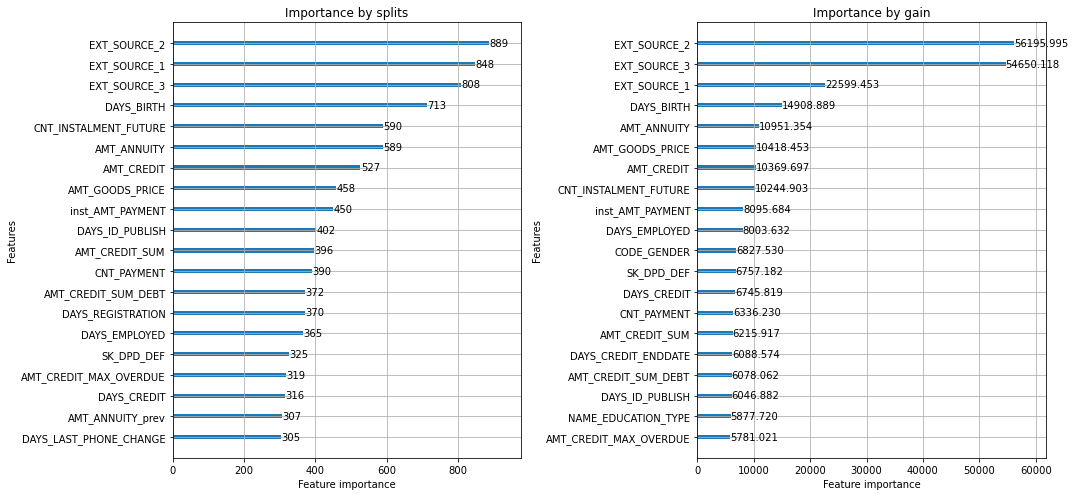

In [191]:
%%time
evals_result = {}
""" Predict on test set and create submission """
clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
#                  valid_sets=[lgbm_train, lgbm_valid],
#                  evals_result=evals_result,
#                  verbose_eval=50,
                 num_boost_round=optimum_boost_rounds)
y_pred = clf.predict(X_test)
# out_df = pd.DataFrame({'SK_ID_CURR': meta_df['SK_ID_CURR'][len_train:], 'TARGET': y_pred})
# out_df.to_csv('submission.csv', index=False)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 7])
# doc sur les paramètres de lgbm.plot_importance
# importance_type (string, optional (default="split")) – How the importance is calculated. 
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
# plt.savefig('feature_importance.png')

In [192]:
y_pred

array([0.39140718, 0.0464643 , 0.19309082, ..., 0.10796066, 0.19248944,
       0.03253717])

In [193]:
fpr, tpr, th = roc_curve(y_test, y_pred)
auc_test =  auc(fpr, tpr)
auc_test

0.7824934568773233

In [194]:
tpr

array([0.00000000e+00, 1.23198226e-04, 7.39189356e-04, ...,
       9.99876802e-01, 1.00000000e+00, 1.00000000e+00])

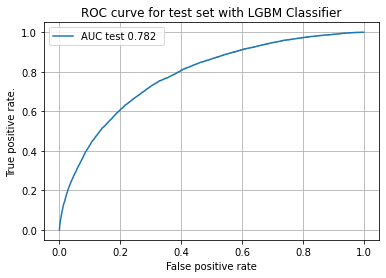

In [195]:
fpr, tpr, th = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"AUC test {auc_test:.3f} ")
plt.legend()
plt.ylabel('True positive rate.')
plt.xlabel('False positive rate')
plt.grid()
plt.title ("ROC curve for test set with LGBM Classifier")
plt.show()


#### Calcul du seuil

Nous travaillons pour un organisme de crédit. Nous voulons donc minimiser le risque que le crédit ne soit pas remboursé. Nous voulons donc minimiser le nombre de faux négatifs, c'est à dire les personnes auxquelles on accorderait un crédit et qui ne seraient pas en mesure de le rembourser.    

Calculons le seuil correspondant à un taux de faux négatifs (FN/(FN+TP))choisi.  
Pour avoir un taux de faux négatifs < 5%, il faut un taux de vrai positifs (TP/(FN+TP))>95%.

In [198]:
fn = 0.05
idx = np.min(np.where(tpr>(1-fn)))
print(f"Pour un taux de faux négatif de {fn*100}%, ")
print(f"le taux de faux positifs est de {fpr[idx]*100:.1f}%,")
print(f"et le seuil est de {th[idx]*100:.1f}%")
seuil = th[idx]


Pour un taux de faux négatif de 5.0%, 
le taux de faux positifs est de 70.9%,
et le seuil est de 5.5%


## Suppression des valeurs nulles

In [81]:
values = dict(data.mean())
values

{'NAME_CONTRACT_TYPE': 0.09521285417432222,
 'CODE_GENDER': 0.6583699444897906,
 'FLAG_OWN_CAR': 0.34010815873253314,
 'FLAG_OWN_REALTY': 0.30632725333402705,
 'CNT_CHILDREN': 0.4170517477423572,
 'AMT_INCOME_TOTAL': 168797.9192969845,
 'AMT_CREDIT': 599025.9997057016,
 'AMT_ANNUITY': 27108.573909183444,
 'AMT_GOODS_PRICE': 538396.2074288895,
 'NAME_TYPE_SUITE': 0.2775120239601185,
 'NAME_INCOME_TYPE': 1.0773468266175845,
 'NAME_EDUCATION_TYPE': 0.3496492808387342,
 'NAME_FAMILY_STATUS': 1.2465765452292763,
 'NAME_HOUSING_TYPE': 0.2737723203397602,
 'REGION_POPULATION_RELATIVE': 0.02086811205778947,
 'DAYS_BIRTH': -16036.995066843137,
 'DAYS_EMPLOYED': 63815.04590404896,
 'DAYS_REGISTRATION': -4986.120327538419,
 'DAYS_ID_PUBLISH': -2994.2023732484367,
 'OWN_CAR_AGE': 12.061090818687727,
 'FLAG_MOBIL': 0.9999967480838083,
 'FLAG_EMP_PHONE': 0.8198893698111612,
 'FLAG_WORK_PHONE': 0.1993684778755882,
 'FLAG_CONT_MOBILE': 0.9981334001060125,
 'FLAG_PHONE': 0.28106636835755466,
 'FLAG_EMA

In [82]:
data2 = data.fillna(value=values)

In [83]:
# On recalcule les jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.33, random_state=42)

## SGDClassifier

In [91]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# sgdc = SGDClassifier(loss="modified_huber")
# params = {"alpha" : np.logspace(-4, 1, 6), "class_weight":[None, "balanced"]}

# model_cv=GridSearchCV(sgdc, params, cv=5, verbose=10)
# model_cv.fit(X_train, y_train)

Heure de début : 2020-04-13 13:10:09.363331
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] alpha=0.0001, class_weight=None .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... alpha=0.0001, class_weight=None, score=0.916, total=   4.6s
[CV] alpha=0.0001, class_weight=None .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ..... alpha=0.0001, class_weight=None, score=0.837, total=   4.4s
[CV] alpha=0.0001, class_weight=None .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


[CV] ..... alpha=0.0001, class_weight=None, score=0.919, total=   4.1s
[CV] alpha=0.0001, class_weight=None .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s


[CV] ..... alpha=0.0001, class_weight=None, score=0.701, total=   3.4s
[CV] alpha=0.0001, class_weight=None .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.5s remaining:    0.0s


[CV] ..... alpha=0.0001, class_weight=None, score=0.460, total=   7.7s
[CV] alpha=0.0001, class_weight=balanced .............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.3s remaining:    0.0s


[CV] . alpha=0.0001, class_weight=balanced, score=0.860, total=   7.1s
[CV] alpha=0.0001, class_weight=balanced .............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.4s remaining:    0.0s


[CV] . alpha=0.0001, class_weight=balanced, score=0.781, total=   5.2s
[CV] alpha=0.0001, class_weight=balanced .............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   36.6s remaining:    0.0s


[CV] . alpha=0.0001, class_weight=balanced, score=0.384, total=  10.5s
[CV] alpha=0.0001, class_weight=balanced .............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   47.1s remaining:    0.0s


[CV] . alpha=0.0001, class_weight=balanced, score=0.459, total=   3.8s
[CV] alpha=0.0001, class_weight=balanced .............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   50.9s remaining:    0.0s


[CV] . alpha=0.0001, class_weight=balanced, score=0.818, total=   8.9s
[CV] alpha=0.001, class_weight=None ..................................
[CV] ...... alpha=0.001, class_weight=None, score=0.908, total=   5.7s
[CV] alpha=0.001, class_weight=None ..................................
[CV] ...... alpha=0.001, class_weight=None, score=0.917, total=   4.8s
[CV] alpha=0.001, class_weight=None ..................................
[CV] ...... alpha=0.001, class_weight=None, score=0.836, total=   3.4s
[CV] alpha=0.001, class_weight=None ..................................
[CV] ...... alpha=0.001, class_weight=None, score=0.913, total=   5.8s
[CV] alpha=0.001, class_weight=None ..................................
[CV] ...... alpha=0.001, class_weight=None, score=0.469, total=   7.1s
[CV] alpha=0.001, class_weight=balanced ..............................
[CV] .. alpha=0.001, class_weight=balanced, score=0.159, total=   4.6s
[CV] alpha=0.001, class_weight=balanced ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.3min finished


Wall time: 6min 23s


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='modified_huber', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'class_weight': [None, 'balanced']},
             pre_dispatch='2*n_jobs', refit=Tru

In [92]:
# print("best score : ", model_cv.best_score_)
# print("best params_ : ", model_cv.best_params_)

best score :  0.903257709040799
best params_ :  {'alpha': 10.0, 'class_weight': None}


In [93]:
# sgdc = SGDClassifier(loss="modified_huber", alpha=model_cv.best_params_["alpha"], 
#                      class_weight=model_cv.best_params_["class_weight"])
# sgdc.fit(X_train, y_train)

SGDClassifier(alpha=10.0, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [94]:
# ret = sgdc.predict_proba(X_test)
# roc_auc_score(y_test, ret[:,1])

0.5013311787231024

0.5013311787231024

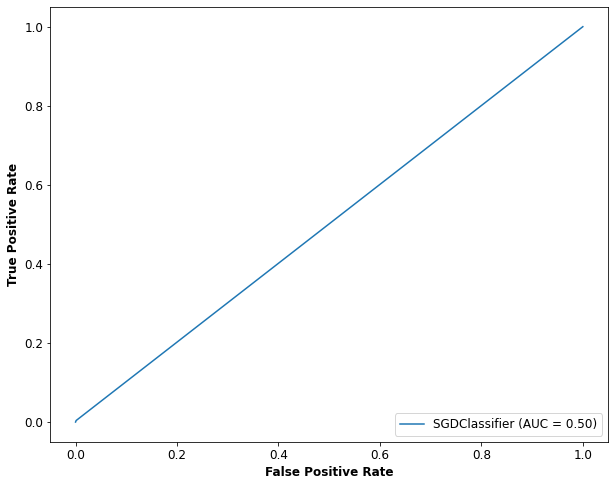

In [95]:
plot_roc_curve(sgdc, X_test, y_test)
plt.show()

## Random Forest Classifier

In [96]:
# %%time
# # Long, environ 14 min par fold pour 1100 estimateurs (1.3 min pour 100 estimateurs) = 1h15 pour les 5 folds avec 
# # 1100 estimateurs, env 2h15 en tout
# print(f"Heure de début : {str(datetime.now())}")

# rfc = RandomForestClassifier()
# params = {"n_estimators": range(100, 1200, 500), "class_weight": ["balanced"]}

# model_cv=GridSearchCV(rfc, params, cv=5, scoring='roc_auc', verbose=10)
# model_cv.fit(X_train, y_train)

In [97]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# print("best score : ", model_cv.best_score_)
# print("best params_ : ", model_cv.best_params_)
# rfc = RandomForestClassifier(n_estimators=model_cv.best_params_["n_estimators"], 
#                              class_weight=model_cv.best_params_["class_weight"])
# rfc.fit(X_train, y_train)

best score :  0.751986168786994
best params_ :  {'class_weight': 'balanced', 'n_estimators': 1100}

In [98]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# ret = rfc.predict_proba(X_test)
# print(roc_auc_score(y_test, ret[:,1]))
# plot_roc_curve(rfc, X_test, y_test)
# plt.show()

AUC = 0.7543927592802018

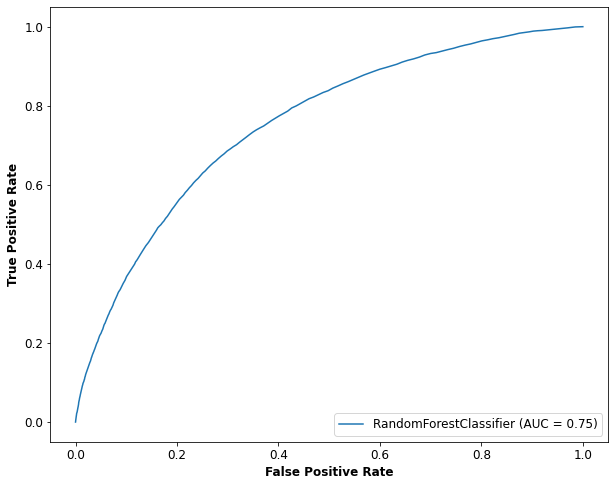

## Gradient Boosting

In [84]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# gbc = GradientBoostingClassifier()
# params = {"learning_rate": np.logspace(0, 1, 2)}

# model_cv=GridSearchCV(gbc, params, cv=5, scoring='roc_auc', verbose=10)
# model_cv.fit(X_train, y_train)

Heure de début : 2020-04-13 15:02:00.156580
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] learning_rate=1.0 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... learning_rate=1.0, score=0.757, total= 4.8min
[CV] learning_rate=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s


[CV] ................... learning_rate=1.0, score=0.749, total= 4.8min
[CV] learning_rate=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.6min remaining:    0.0s


[CV] ................... learning_rate=1.0, score=0.748, total= 4.8min
[CV] learning_rate=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.4min remaining:    0.0s


[CV] ................... learning_rate=1.0, score=0.753, total= 4.8min
[CV] learning_rate=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.2min remaining:    0.0s


[CV] ................... learning_rate=1.0, score=0.754, total= 4.9min
[CV] learning_rate=10.0 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 24.1min remaining:    0.0s


[CV] .................. learning_rate=10.0, score=0.623, total= 4.9min
[CV] learning_rate=10.0 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 29.0min remaining:    0.0s


[CV] .................. learning_rate=10.0, score=0.626, total= 4.9min
[CV] learning_rate=10.0 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 33.9min remaining:    0.0s


[CV] .................. learning_rate=10.0, score=0.638, total= 4.9min
[CV] learning_rate=10.0 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 38.9min remaining:    0.0s


[CV] .................. learning_rate=10.0, score=0.632, total= 5.0min
[CV] learning_rate=10.0 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 43.9min remaining:    0.0s


[CV] .................. learning_rate=10.0, score=0.620, total= 5.0min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 48.8min finished


Wall time: 54min 55s


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

Résultats pour learning rate à 0.01 , 0.1 , 1 et 10 
CV] learning_rate=0.01 ..............................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] .................. learning_rate=0.01, score=0.714, total= 4.7min
[CV] learning_rate=0.01 ..............................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s
[CV] .................. learning_rate=0.01, score=0.717, total= 4.7min
[CV] learning_rate=0.01 ..............................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.5min remaining:    0.0s
[CV] .................. learning_rate=0.01, score=0.712, total= 4.7min
[CV] learning_rate=0.01 ..............................................
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.2min remaining:    0.0s
[CV] .................. learning_rate=0.01, score=0.719, total= 4.7min
[CV] learning_rate=0.01 ..............................................
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.9min remaining:    0.0s
[CV] .................. learning_rate=0.01, score=0.710, total= 4.7min
[CV] learning_rate=0.1 ...............................................
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 23.7min remaining:    0.0s
[CV] ................... learning_rate=0.1, score=0.768, total= 4.7min
[CV] learning_rate=0.1 ...............................................
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 28.4min remaining:    0.0s
[CV] ................... learning_rate=0.1, score=0.765, total= 4.7min
[CV] learning_rate=0.1 ...............................................
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 33.1min remaining:    0.0s
[CV] ................... learning_rate=0.1, score=0.762, total= 4.7min
[CV] learning_rate=0.1 ...............................................
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 37.8min remaining:    0.0s
[CV] ................... learning_rate=0.1, score=0.769, total= 4.8min
[CV] learning_rate=0.1 ...............................................
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 42.6min remaining:    0.0s
[CV] ................... learning_rate=0.1, score=0.764, total= 5.0min

[CV] learning_rate=1.0 ...............................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ................... learning_rate=1.0, score=0.757, total= 4.8min
[CV] learning_rate=1.0 ...............................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s
[CV] ................... learning_rate=1.0, score=0.749, total= 4.8min
[CV] learning_rate=1.0 ...............................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.6min remaining:    0.0s
[CV] ................... learning_rate=1.0, score=0.748, total= 4.8min
[CV] learning_rate=1.0 ...............................................
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.4min remaining:    0.0s
[CV] ................... learning_rate=1.0, score=0.753, total= 4.8min
[CV] learning_rate=1.0 ...............................................
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.2min remaining:    0.0s
[CV] ................... learning_rate=1.0, score=0.754, total= 4.9min
[CV] learning_rate=10.0 ..............................................
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 24.1min remaining:    0.0s
[CV] .................. learning_rate=10.0, score=0.623, total= 4.9min
[CV] learning_rate=10.0 ..............................................
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 29.0min remaining:    0.0s
[CV] .................. learning_rate=10.0, score=0.626, total= 4.9min
[CV] learning_rate=10.0 ..............................................
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 33.9min remaining:    0.0s
[CV] .................. learning_rate=10.0, score=0.638, total= 4.9min
[CV] learning_rate=10.0 ..............................................
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 38.9min remaining:    0.0s
[CV] .................. learning_rate=10.0, score=0.632, total= 5.0min
[CV] learning_rate=10.0 ..............................................
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 43.9min remaining:    0.0s
[CV] .................. learning_rate=10.0, score=0.620, total= 5.0min
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 48.8min finished

In [100]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# print("best score : ", model_cv.best_score_)
# print("best params_ : ", model_cv.best_params_)
# gbc = GradientBoostingClassifier(learning_rate=model_cv.best_params_["learning_rate"])
# gbc.fit(X_train, y_train)

Heure de début : 2020-04-13 14:07:26.191831


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [101]:
# %%time
# print(f"Heure de début : {str(datetime.now())}")

# ret = gbc.predict_proba(X_test)
# print(roc_auc_score(y_test, ret[:,1]))
# plot_roc_curve(gbc, X_test, y_test)
# plt.show()

Heure de début : 2020-04-13 14:07:26.264636


NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Explicabilité

## Préparation des données

Nous reprenons le modèle qui a déjà été entraîné et nous l'utilisons maintenant pour prédire la totalité des données.

In [67]:
y_pred = clf.predict(data)
y_pred

array([0.58203211, 0.02959848, 0.04987688, ..., 0.12610929, 0.19449604,
       0.16540364])

In [59]:
# fpr, tpr, th = roc_curve(y, y_pred[:,1])
# auc_test =  auc(fpr, tpr)
# auc_test

0.8570688281388494

In [172]:
data_applicant = pd.concat([applicants, pd.Series(y_pred, name="score"), data], axis=1)
data_applicant

,SK_ID_CURR,score,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent_proposal,cc_bal_cc_bal_status__Signed,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0.582032,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0.029598,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0.049877,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0.040476,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0.084308,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.158076,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,1.142857,4.000000,-120.000000,-156.285714,7492.924286,7492.924286
307507,456252,0.222661,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,1.000000,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500
307508,456253,0.126109,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,1.000000,4.785714,-2372.928571,-2387.428571,4399.707857,4115.915357
307509,456254,0.194496,0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,1.000000,5.263158,-142.263158,-161.263158,10239.832895,10239.832895


In [183]:
feature_gain = pd.concat([pd.Series(clf.feature_name(), name="feature"),
    pd.Series(clf.feature_importance(importance_type='gain'), name="gain")], axis=1)
feature_gain.sort_values(by="gain", ascending=False).head(20)

,feature,gain
40,EXT_SOURCE_2,56447.297174
41,EXT_SOURCE_3,55389.066724
39,EXT_SOURCE_1,24445.870153
15,DAYS_BIRTH,14572.049343
7,AMT_ANNUITY,10961.398884
8,AMT_GOODS_PRICE,10231.302187
329,CNT_INSTALMENT_FUTURE,9292.790334
6,AMT_CREDIT,8326.167693
16,DAYS_EMPLOYED,7861.310000
373,inst_AMT_PAYMENT,7836.330590


In [169]:
(feature_gain["gain"]==0.).sum()

86

## Analyse d'une demande

In [ ]:
np.random.seed(42)

In [141]:
this_client = np.random.randint(0, len(y))
this_client

146867

### Description du client

In [207]:
no_client = data_applicant.loc[this_client, "SK_ID_CURR"]
print("numéro de client : ", no_client)
genre = data_applicant.loc[no_client, "CODE_GENDER"]
if genre==0:
    print("genre : masculin")
else :
    print("genre : féminin")
age_jours = data_applicant.loc[this_client, "DAYS_BIRTH"]
print(f"âge : {-age_jours/365:.0f} ans")

numéro de client :  270275
genre : masculin
âge : 35 ans


In [241]:
df_homecredit[df_homecredit["Row"]=="CNT_INSTALMENT"]

,Unnamed: 0,Table,Row,Description,Special
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN


In [224]:
list(df_homecredit[df_homecredit["Row"]=="AMT_GOODS_PRICE"]["Description"])

['For consumer loans it is the price of the goods for which the loan is given',
 'Goods price of good that client asked for (if applicable) on the previous application']

In [232]:
# df_application_train["AMT_ANNUITY"].describe()
df_pos_cash_balance["CNT_INSTALMENT_FUTURE"].describe()

count    9.975271e+06
mean     1.048384e+01
std      1.110906e+01
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.400000e+01
max      8.500000e+01
Name: CNT_INSTALMENT_FUTURE, dtype: float64

In [242]:
df_prev_app.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

### Score et interprétation

In [230]:
score = data_applicant.loc[this_client, "score"]
print("Score : " + f"{score*100:.1f} %")
if score < seuil :
    print("==> pas de risque particulier")
else :
    print("client à risque")
score_ext_1, score_ext_2, score_ext_3 = data_applicant.loc[this_client, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]]
print(f"Scores externes : score 1 : {score_ext_1*100:.0f}%, score 2 : {score_ext_2*100:.0f}%, score 3 : {score_ext_3*100:.0f}%")
annuity = data_applicant.loc[this_client, "AMT_ANNUITY"]
print(f"Montant de l'annuité : {annuity:.2f}")
goods_price = data_applicant.loc[this_client, "AMT_GOODS_PRICE"]
print(f"Prix du bien acheté : {goods_price}")
installment_prev_credit = data_applicant.loc[this_client, "CNT_INSTALMENT_FUTURE"]
print(f"Nombre de versements restants de précédents crédits : {installment_prev_credit}")

Score : 4.6 %
==> pas de risque particulier
Scores externes : score 1 : 61%, score 2 : 60%, score 3 : 26%
Montant de l'annuité : 13500.00
Prix du bien acheté : 270000.0
Versements restants de précédents crédits : 6.8


### Comparaison à des clients semblables